
# Import and model

In [22]:
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import torch
import pickle
import os
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from ranx import Run, fuse
import faiss

In [23]:
def normalize_data(data):
    # Kiểm tra nếu data là một vector 1 chiều
    if data.ndim == 1:
        normalized_data = data / np.linalg.norm(data)
    else:
        # Chuẩn hóa dữ liệu nếu là mảng 2 chiều
        normalized_data = data / np.linalg.norm(data, axis=1, keepdims=True)
    
    return normalized_data

In [24]:
def load_file_lines(file_path):
    """Đọc toàn bộ dòng từ một file và trả về danh sách các dòng."""
    try:
        with open(file_path, 'r') as f:
            return [line.strip() for line in f]
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại!")
        return []

In [25]:
def precision(true_positives, retrieved):
  return true_positives / retrieved if retrieved != 0 else 0

def recall(true_positives, relevant):
  return true_positives / relevant if relevant != 0 else 0

def f1_score(precision, recall):
  return 2 * precision * recall / (precision + recall)

def average_precision(relevant_items, retrieved_items):
  '''
  relevant_items: list các ID mà thực sự là đúng
  retrieved_items: list các ID được truy vấn trả về
  '''
  relevant_items = set(relevant_items)
  retrieved = 0
  true_positives = 0
  pres = []

  for i, item in enumerate(retrieved_items):
    retrieved += 1
    if item in relevant_items:
      true_positives += 1
      pres.append(precision(true_positives, retrieved))

  return np.mean(pres) if pres else 0

def mean_average_precision(queries):
  aps = [average_precision(q[0], q[1]) for q in queries]
  return np.mean(aps) if aps else 0

# Hàm vẽ Precision-Recall Curve
def plot_precision_recall_curve(queries, tittle='Precision-Recall Curve'):
    plt.figure(figsize=(10, 6))

    for idx, (relevant_items, retrieved_items) in enumerate(queries):
        relevant_items = set(relevant_items)
        precision_vals = []
        recall_vals = []
        true_positives = 0

        # Tính Precision và Recall cho từng ngưỡng
        for i, item in enumerate(retrieved_items):
            if item in relevant_items:
                true_positives += 1
            p = precision(true_positives, i + 1)
            r = recall(true_positives, len(relevant_items))
            precision_vals.append(p)
            recall_vals.append(r)

        auc_score = auc(recall_vals, precision_vals)

        # Vẽ đường Precision-Recall cho từng truy vấn
        plt.plot(recall_vals, precision_vals, label=f'AUC = {auc_score:.2f}')

    # Cấu hình biểu đồ
    plt.title(tittle)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
def process_queries(query_file, device='cpu'):
    """
    Đọc file query, cắt ảnh theo bounding box và extract feature theo từng bb.
    
    :param query_file: Đường dẫn đến file query.txt
    :param image_folder: Thư mục chứa ảnh
    """
    with open(query_file, 'r') as file:
        features = []
        for line in file:
            # Tách dòng query thành các phần tử
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            
            image_name = parts[0] + '.jpg'  # Tên file ảnh
            x1, y1, x2, y2 = map(float, parts[1:])  # Bounding box
            
            # Đường dẫn đầy đủ đến ảnh
            image_path = os.path.join(data_path, image_name.split('_')[1], image_name)
            
            # Kiểm tra ảnh tồn tại
            if not os.path.exists(image_path):
                print(f"Ảnh {image_name} không tồn tại trong thư mục {os.path.join(data_path, image_name.split('_')[1])}.")
                continue
            
            # Mở ảnh và cắt theo bounding box
            with Image.open(image_path).convert('RGB') as img:
                cropped_img = img.crop((x1, y1, x2, y2))  # Cắt ảnh
                # Extract feature của ảnh crop
                cropped_img = transform(cropped_img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feature = model.get_image_features(cropped_img)
                feature = feature.squeeze().cpu().numpy()
                features.append(feature)
        
        return features

In [27]:
def get_clip_features(image_paths, device='cpu'):
    features = []
    for image_path in image_paths:
        if not os.path.exists(image_path):
            print(f"Ảnh  không tồn tại trong thư mục.")
            continue

        with Image.open(image_path).convert('RGB') as img:
            # Extract feature của ảnh crop
            img = transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = model.get_image_features(img)
            feature = feature.squeeze().cpu().numpy()
            features.append(feature)
        
    return features

In [28]:
def merge_results_by_ranx(list_rank_list, list_similarity_matrix, method='rrf'): # Merge kết quả của từng query.
  # Chuyển đổi dữ liệu sang dạng dictionary
  runs = []
  for i, (res, sims) in enumerate(zip(list_rank_list, list_similarity_matrix)):
      query_id = f"query_0"
      run_data = {str(doc_id): score for doc_id, score in zip(res, sims)}
      run = Run({query_id: run_data})
      runs.append(run)
  # Hợp nhất kết quả
  fused_run = fuse(runs, method=method)  # Có thể điều chỉnh weights nếu cần

  fused_ranking_results = {}

  for query_id, docs in fused_run.to_dict().items():
      fused_ranking_results[query_id] = list(docs.keys())  # Lấy danh sách document IDs (không cần điểm số)

  return fused_ranking_results['query_0']

In [29]:
def get_path(list_image):
    results = []
    for name in list_image:
        folder = name.split('_')[1]
        image_path = os.path.join(data_path, folder, f'{name}.jpg')
        results.append(image_path)

    return results

# get_path(rank_list[0][:top_rerank])

# Parameters

In [30]:
k = 6392
retrain = True
top_rerank = 3

gt_path = r'C:\Retrieval System\data\paris_120310_gt'
data_path = r'C:\Retrieval System\Multimedia-Information-Retrieval\static\data\paris'
features_path = r'C:\Retrieval System\features\features_paris_clip_3'

In [31]:
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
if retrain:
    model = torch.load(r'C:\Retrieval System\model\paris_clip_3.pth', map_location=torch.device('cpu'))

model.eval()

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

c:\Users\DELL\miniconda3\envs\CS336\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Get input features

In [32]:
query = []
map_qr = []
for file in os.listdir(gt_path):
    if 'query' in file:
        # print(file)
        map_qr.append(file.split('.')[0])
        query_file = os.path.join(gt_path, file)
        features = process_queries(query_file=query_file)
        if len(features) == 1:
            query.append(features[0])

query = np.array(query)
map_qr = [name[:-6] if name.endswith("_query") else name for name in map_qr]
print(map_qr)
query.shape

['defense_1', 'defense_2', 'defense_3', 'defense_4', 'defense_5', 'eiffel_1', 'eiffel_2', 'eiffel_3', 'eiffel_4', 'eiffel_5', 'invalides_1', 'invalides_2', 'invalides_3', 'invalides_4', 'invalides_5', 'louvre_1', 'louvre_2', 'louvre_3', 'louvre_4', 'louvre_5', 'moulinrouge_1', 'moulinrouge_2', 'moulinrouge_3', 'moulinrouge_4', 'moulinrouge_5', 'museedorsay_1', 'museedorsay_2', 'museedorsay_3', 'museedorsay_4', 'museedorsay_5', 'notredame_1', 'notredame_2', 'notredame_3', 'notredame_4', 'notredame_5', 'pantheon_1', 'pantheon_2', 'pantheon_3', 'pantheon_4', 'pantheon_5', 'pompidou_1', 'pompidou_2', 'pompidou_3', 'pompidou_4', 'pompidou_5', 'sacrecoeur_1', 'sacrecoeur_2', 'sacrecoeur_3', 'sacrecoeur_4', 'sacrecoeur_5', 'triomphe_1', 'triomphe_2', 'triomphe_3', 'triomphe_4', 'triomphe_5']


(55, 512)

In [33]:
query = normalize_data(data=query)
query.shape

(55, 512)

# Load database

In [34]:
# database = []
# map_db = []
# for file in os.listdir(features_path):
#     file_path = os.path.join(features_path, file)

#     with open(file_path, "rb") as f:
#         image_features_data = pickle.load(f) # 1 list, các phần tử là dict với image_name và features

#         for item in image_features_data:
#             database.append(item['features'])
#             map_db.append(item['image_name'].replace('.jpg',''))

# database = np.array(database)
# database.shape

In [35]:
with open(r'C:\Retrieval System\Multimedia-Information-Retrieval\index\IndexPQ_paris_clip.pkl', 'rb') as f:
    database = pickle.load(f)
    index = database["index"]
    map_index = database["map_index"]

map_db = [filename.replace('.jpg', '') for filename in map_index]

print(index.is_trained)
print(index.ntotal)

True
6392


# Retrieval

In [36]:
def retrieval_top_k(query, index, k=5):
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    top_k_similarities, top_k_indices = index.search(query, k)
    os.environ["KMP_DUPLICATE_LIB_OK"] = "FALSE"

    top_k = []
    for i in range(top_k_indices.shape[0]):
        top_k.append([map_db[j] for j in top_k_indices[i]])

    return top_k, top_k_similarities.tolist()

# retrieval_top_k(query=query, database=database, k=2)

In [37]:
rank_list, similarity_matrix = retrieval_top_k(query=query, index=index, k=k)

In [38]:
first_rank_list, first_similarity_matrix = rank_list, similarity_matrix

# Evaluate

In [39]:
ground_truths = []
for query_name in map_qr:
    file_ok = os.path.join(gt_path, f"{query_name}_ok.txt")
    file_good = os.path.join(gt_path, f"{query_name}_good.txt")

    # Đọc dòng từ từng file
    lines_ok = load_file_lines(file_ok)
    lines_good = load_file_lines(file_good)

    # Gộp nội dung 2 file thành 1 danh sách
    merged_list = lines_good + lines_ok

    ground_truths.append(merged_list)

In [40]:
queries = []
for i in range(len(rank_list)):
    relevant_items = ground_truths[i]
    retrieved_items = rank_list[i]
    queries.append((relevant_items, retrieved_items))
    # plot_precision_recall_curve(queries=[(relevant_items, retrieved_items)], tittle=f'Precision-Recall Curve of query {i+1}')
    # print(average_precision(relevant_items=relevant_items, retrieved_items=retrieved_items))

In [41]:
mean_average_precision(queries=queries)

0.7868496508899491

# Re-ranking

In [42]:
result_mnz = []
for i in range(5):
    new_rank_list = []
    for i in range(len(query)):
        new_query = np.array(get_clip_features(get_path(rank_list[i][:top_rerank])))
        new_query = normalize_data(data=new_query)
        list_rank_list, list_similarity_matrix = retrieval_top_k(query=new_query, index=index, k=k)
        list_similarity_matrix = [row[::-1] for row in list_similarity_matrix]
        each_rank_list = merge_results_by_ranx(list_rank_list, list_similarity_matrix, method='mnz')
        new_rank_list.append(each_rank_list)

    rank_list = new_rank_list
    queries = []
    for i in range(len(rank_list)):
        relevant_items = ground_truths[i]
        retrieved_items = new_rank_list[i]
        queries.append((relevant_items, retrieved_items))
    print(mean_average_precision(queries=queries))
    result_mnz.append(mean_average_precision(queries=queries))


0.807768294649371
0.8106740994032748
0.8099076970878167
0.8096746203042778
0.8093499376778084


In [43]:
rank_list, similarity_matrix = first_rank_list, first_similarity_matrix 

In [44]:
result_rrf = []
for i in range(5):
    new_rank_list = []
    for i in range(len(query)):
        new_query = np.array(get_clip_features(get_path(rank_list[i][:top_rerank])))
        new_query = normalize_data(data=new_query)
        list_rank_list, list_similarity_matrix = retrieval_top_k(query=new_query, index=index, k=k)
        list_similarity_matrix = [row[::-1] for row in list_similarity_matrix]
        each_rank_list = merge_results_by_ranx(list_rank_list, list_similarity_matrix, method='rrf')
        new_rank_list.append(each_rank_list)

    rank_list = new_rank_list
    queries = []
    for i in range(len(rank_list)):
        relevant_items = ground_truths[i]
        retrieved_items = rank_list[i]
        queries.append((relevant_items, retrieved_items))
    print(mean_average_precision(queries=queries))
    result_rrf.append(mean_average_precision(queries=queries))


0.808379771941827
0.8137356408325135
0.814837734784923
0.8155675974395767
0.8163552929623031


C:\Users\DELL\AppData\Local\Temp\ipykernel_17696\3768079444.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


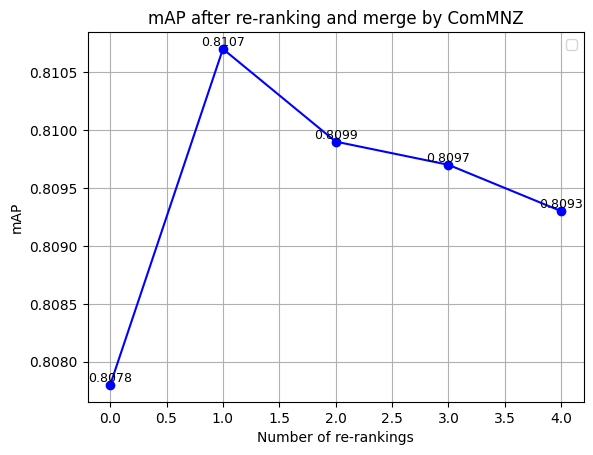

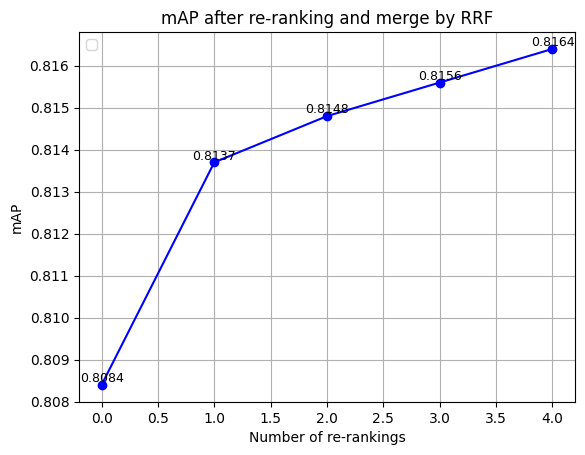

In [45]:
def plot_reranking_history(history, tittle=''):
    # Làm tròn kết quả đến 4 chữ số thập phân
    rounded_results = [round(val, 4) for val in history]

    # Vẽ đường kết quả
    plt.plot(rounded_results, marker='o', linestyle='-', color='b')

    # Hiển thị các giá trị trên từng điểm dữ liệu
    for i, val in enumerate(rounded_results):
        plt.text(i, val, str(val), ha='center', va='bottom', fontsize=9)  # Chỉnh vị trí hiển thị giá trị

    # Thêm tiêu đề và nhãn trục
    plt.title(f'mAP after re-ranking and merge by {tittle}')
    plt.xlabel('Number of re-rankings')
    plt.ylabel('mAP')

    # Hiển thị đồ thị
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reranking_history(result_mnz, tittle='ComMNZ')
# plot_reranking_history(result_bf, tillte='Bordafuse')
plot_reranking_history(result_rrf, tittle='RRF')
